## [PyTorch] Matrix Factorization

pytorchで行列分解(Matrix Factorization)をやってみる。


### データセット

### 評価指標
#### ランキング上位
- recall
- precision
- nDCG

#### 多様性の評価
- ユークリッド距離

### model

- MF
- 

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/gcn/base_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/gcn/base_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	macOS
ProductVersion:	11.6.7
BuildVersion:	20G630


In [2]:
!python -V

Python 3.8.13


基本的なライブラリをインポートしそのバージョンを確認しておきます。
学習をpytorchを利用し、ネットワーク関係はnetworkxを利用する。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

from tabulate import tabulate

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib

print('matplotlib  : {}'.format(matplotlib.__version__))
print('networkdx   : {}'.format(nx.__version__))
print('numpy       : {}'.format(np.__version__))
print('torch       : {}'.format(torch.__version__))

matplotlib  : 3.5.1
networkdx   : 2.7.1
numpy       : 1.22.3
torch       : 1.12.0


## dataの読み込み

In [4]:
in_ml_1m_file_name = '../dataset/ml-1m/ml-1m.csv'

df = pd.read_csv(in_ml_1m_file_name)
df.groupby('user_id').filter(lambda x: x['item_id'].count() > 100) \
    .groupby('user_id').count().sort_values('item_id', ascending=False)


from enum import Enum


class Dataset(Enum):

    ml_100k = 'ml_100k'
    ml_1m = 'ml_1m'
    Gowalla = 'Gowalla'
    Yelp = 'Yelp'
    Amazon_Books = 'Amazon_Books'

    def __init__(self, name):
        pass

    def __str__(self):
        return self.name

    def __call__(self):
        return self.get_df()

    def get_df(self) -> pd.DataFrame:
        if self.name == str(self.ml_1m):
            self.dataset_name = '../dataset/ml-1m/ml-1m.csv'
            return pd.read_csv(self.dataset_name)
        raise ValueError()


df = Dataset('ml_1m')()
df
# df.groupby('user_id').filter(lambda x: x['item_id'].count() > 23).groupby('user_id').agg(
#     len).aggregate([len, max, min, np.mean]).sort_values(by='item_id', ascending=False)

# .droplevel(0, axis=1).sort_values(by='len', ascending=False)

# .count().sort_values(by='item_id', ascending=False)

# .aggregate([len, max, min, np.mean, np.std]).droplevel(0, axis=1).sort_values(by='len', ascending=False)


,user_id,item_id
0,1,1193
1,1,661
2,1,914
3,1,3408
4,1,2355
...,...,...
1000204,6040,1091
1000205,6040,1094
1000206,6040,562
1000207,6040,1096


In [5]:
class BloodType(Enum):
    A = 'A'
    B = 'B'
    O = 'O'
    AB = 'AB'

BloodType('A')

<BloodType.A: 'A'>

In [6]:
df.groupby('user_id').agg({'item_id': len}).sort_values(by='item_id', ascending=False).tail()
df.groupby('user_id').agg({'item_id': len}).agg({'item_id': [max, min, np.mean, len]})

,item_id
max,2314.000000
min,20.000000
mean,165.597517
len,6040.000000


In [7]:
df.groupby('user_id').count().sort_values(by='item_id', ascending=False)

,item_id
user_id,
4169,2314
1680,1850
4277,1743
1941,1595
1181,1521
...,...
5725,20
3407,20
1664,20


In [8]:
@np.vectorize 
def v_avg_2_mod(x, y): 
    """xが20でなければ平均値を計算する。
    前と同様だがデコレータでベクトル化する
    """ 
    if (x == 20): 
        return(np.NaN) 
    else: 
        return (x + y) / 2

v_avg_2_mod(1,3)
# v_avg_2_mod([3,1],[2,33])

array(2.)

In [9]:
df = pd.DataFrame({
    'item':['apple', 'apple', 'apple', 'windows', 'windows', 'linux'],
    'sales':[3,4,5,8,7,2],
})

df.groupby('item').agg({'sales': len}).sort_values(by='sales', ascending=False)

,sales
item,
apple,3
windows,2
linux,1


In [10]:
df.groupby('item').get_group('windows')

,item,sales
3,windows,8
4,windows,7


In [11]:
df.groupby('item').first()

,sales
item,
apple,3
linux,2
windows,8


In [12]:
df.groupby('item').last()

,sales
item,
apple,5
linux,2
windows,7


In [13]:
import pandas_datareader as pdr 
# この例ではTeslaに関する株価情報を取得する
tesla = pdr. get_data_yahoo ('TSLA') 
tesla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-07-27,69.500000,65.258003,69.199997,66.891998,41512000.0,66.891998
2017-07-28,67.919998,66.501999,67.377998,67.014000,24402000.0,67.014000
2017-07-31,68.297997,64.208000,67.099998,64.694000,42675500.0,64.694000
2017-08-01,64.889999,63.226002,64.599998,63.914001,41515500.0,63.914001
2017-08-02,65.424004,62.243999,63.787998,65.178001,65457500.0,65.178001
...,...,...,...,...,...,...
2022-07-21,819.799988,764.599976,765.320007,815.119995,47344100.0,815.119995
2022-07-22,842.359985,812.140015,828.659973,816.729980,34421200.0,816.729980
2022-07-25,822.440002,802.200012,816.650024,805.299988,21357800.0,805.299988


In [14]:
pd.date_range(start='2014-12-31', end='2015-01-05', freq='B')

DatetimeIndex(['2014-12-31', '2015-01-01', '2015-01-02', '2015-01-05'], dtype='datetime64[ns]', freq='B')

In [15]:
pd.factorize(['a', 'q', 'c', 'd', 'a', 'a', 'e'], sort=True)

(array([0, 4, 1, 2, 0, 0, 3]), array(['a', 'c', 'd', 'e', 'q'], dtype=object))

In [16]:
pd.factorize([1, 3, 5, 7, 8, 10, 2, 4], sort=True)


(array([0, 2, 4, 5, 6, 7, 1, 3]), array([ 1,  2,  3,  4,  5,  7,  8, 10]))

## RecBoleの基本的な流れ

この流れは変わらない

1. config
    - epoch
    - seed
2. dataset
    - load 
    - train/test split
3. model
4. train
5. evaluate


    # configurations initialization
    config = Config(model=model, dataset=dataset, config_file_list=config_file_list, config_dict=config_dict)
    init_seed(config['seed'], config['reproducibility'])
    # logger initialization
    init_logger(config)
    logger = getLogger()

    logger.info(config)

    # dataset filtering
    dataset = create_dataset(config)
    if config['save_dataset']:
        dataset.save()
    logger.info(dataset)

    # dataset splitting
    train_data, valid_data, test_data = data_preparation(config, dataset)
    if config['save_dataloaders']:
        save_split_dataloaders(config, dataloaders=(train_data, valid_data, test_data))

    # model loading and initialization
    # モデルクラス取得
    model = get_model(config['model'])(config, train_data.dataset).to(config['device'])
    logger.info(model)

    # trainer loading and initialization
    trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)

    # model training
    best_valid_score, best_valid_result = trainer.fit(
        train_data, valid_data, saved=saved, show_progress=config['show_progress']
    )

    # model evaluation
    test_result = trainer.evaluate(test_data, load_best_model=saved, show_progress=config['show_progress'])

    logger.info(set_color('best valid ', 'yellow') + f': {best_valid_result}')
    logger.info(set_color('test result', 'yellow') + f': {test_result}')



## config

In [17]:
import random

epochs = 300

seed = 123

def init_seed(seed, reproducibility=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

init_seed(seed)


## dataset

In [18]:
n_test_users = 3
n_test_items = 5

n_users = 1000
n_items = 1000

from scipy import sparse
from scipy.sparse import coo_matrix


class TestDataset:
    def __init__(self):
        self.row = torch.tensor([0, 0, 0, 1, 1, 1, 2, 2])
        self.col = torch.tensor([0, 1, 4, 0, 1, 3, 1, 2])
        self.data = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1])

        self.shape = (n_test_users, n_test_items)

    def __call__(self):
        return coo_matrix((self.data, (self.row, self.col)), shape=self.shape)

    def __repr__(self):
        return 'array : \n{}'.format(coo_matrix((self.data, (self.row, self.col)), shape=self.shape).toarray())

    def __str__(self):
        return 'array : \n{}'.format(coo_matrix((self.data, (self.row, self.col)), shape=self.shape).toarray())

    def to_numpy(self):
        return coo_matrix((self.data, (self.row, self.col)), shape=self.shape).toarray()

    def __iter__(self):
        for d, r, c in zip(self.data, self.row, self.col):
            yield (d, (r, c))


class Dataset:
    def __init__(self, n_users, n_items):
        self.n_users = n_users
        self.n_items = n_items
        self.A = sparse.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        self.A[0, 1] = 1
        self.A[1, 1] = 2


TestDataset()()
TestDataset().to_numpy()


array([[1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0]])

## model

In [19]:
class RegLoss(nn.Module):

    def __init__(self):
        super(RegLoss, self).__init__()

    def forward(self, parameters):
        reg_loss = None
        for W in parameters:
            if reg_loss is None:
                reg_loss = W.norm(2)
            else:
                reg_loss = reg_loss + W.norm(2)
        return reg_loss


class MF(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, config=None, dataset=None):
        super(MF, self).__init__()
        self.user_embedding = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_embedding = torch.nn.Embedding(n_items, n_factors, sparse=True)

        self.reg_loss = RegLoss()

        # self.reg_loss = self.reg_loss(u_ego_embeddings, pos_ego_embeddings, neg_ego_embeddings)
        # self.loss = mf_loss + self.reg_weight * reg_loss

    def forward(self, user_idx, item_idx):
        # return (self.user_embedding(user) * self.item_embedding(item)).sum(1)
        return torch.matmul(self.user_embedding(user_idx), self.item_embedding(item_idx).T)

    def to_matrix(self):
        return torch.matmul(self.user_embedding.weight, self.item_embedding.weight.T)

    def get_regloss(self):
        return 0.01 * (torch.pow(self.user_embedding.weight, 2).sum() + torch.pow(self.item_embedding.weight, 2).sum())


# model = MF(n_test_users, n_test_items, n_factors=128)
# loss_function = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-2)
# optimizer = optim.Adam(model.parameters(), lr=1e-2)


In [20]:
a = torch.nn.Embedding(1, 3, sparse=True)
b = torch.nn.Embedding(1, 3, sparse=True)
print(torch.mul(a(torch.tensor([i for i in range(1)])), b(torch.tensor([i for i in range(1)]))).sum(1))
print(torch.matmul(a(torch.tensor([i for i in range(1)])), b(torch.tensor([i for i in range(1)])).T))

RegLoss()(torch.tensor([[1,2],[3,5]], dtype=float))
# RegLoss()(torch.tensor([[1,2]], dtype=float))


tensor([-0.1946], grad_fn=<SumBackward1>)
tensor([[-0.1946]], grad_fn=<MmBackward0>)


tensor(8.0670, dtype=torch.float64)

In [21]:
np.sqrt(np.power([[1,2]], 2).sum()) + np.sqrt(np.power([[3,5]], 2).sum())
# np.power([[1,2],[3,5]], 2).sum()

8.06701987234509

In [22]:
torch.pow(torch.tensor([[1,2], [2,3]]), 2)
torch.pow(torch.tensor([[1,2], [2,3]]), 2).sum()

tensor(18)

## train

In [23]:

from torch import autograd


model = MF(n_test_users, n_test_items, n_factors=4)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

# epochs: 300
# train_batch_size: 2048
# learner: adam
# learning_rate: 0.001
# weight_decay: 0.0

last_accum_loss = 10000000
for _idx in range(epochs):
    accum_loss = 0.

    for data, (user_idx, item_idx) in TestDataset():

        model.zero_grad()
        prediction = model(user_idx, item_idx).double()
        loss = loss_function(prediction, torch.tensor(data, dtype=float)) + model.get_regloss()

        print('epoch id : {}'.format(_idx))
        print('  prediciton : {}'.format(prediction))
        print('  data       : {}'.format(data))
        print('  loss       : {}'.format(loss))

        accum_loss += loss.item()

        loss.backward()
        optimizer.step()

    print('loss ', _idx + 1, accum_loss)
    if abs(accum_loss - last_accum_loss) < 1e-3:
        break
    last_accum_loss = accum_loss


# print(' (0, 0) = {}'.format(model(0, 0).item()))
# print(' (0, 1) = {}'.format(model(0, 1).item()))
# print(' (0, 2) = {}'.format(model(0, 2).item()))
print(model.to_matrix().to('cpu').detach().numpy().copy().round(2))

TestDataset().to_numpy()


/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_4281/3231496536.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352448001/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  return torch.matmul(self.user_embedding(user_idx), self.item_embedding(item_idx).T)
/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_4281/551037358.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(prediction, torch.tensor(data, dtype=float)) + model.get_regloss()


epoch id : 0
  prediciton : 1.0394693613052368
  data       : 1
  loss       : 0.21184644451649604
epoch id : 0
  prediciton : 1.6583044528961182
  data       : 1
  loss       : 0.6435364522267832
epoch id : 0
  prediciton : 1.5193755626678467
  data       : 1
  loss       : 0.4789790287855453
epoch id : 0
  prediciton : -0.55612713098526
  data       : 1
  loss       : 2.6300521198381297
epoch id : 0
  prediciton : 0.4438149333000183
  data       : 1
  loss       : 0.5171171530031167
epoch id : 0
  prediciton : 0.5148056149482727
  data       : 1
  loss       : 0.4433116865358535
epoch id : 0
  prediciton : -1.863770842552185
  data       : 1
  loss       : 8.409199893825544
epoch id : 0
  prediciton : 0.05675995349884033
  data       : 1
  loss       : 1.093628557202706
loss  1 14.427671335934175
epoch id : 1
  prediciton : 0.9671222567558289
  data       : 1
  loss       : 0.20498146203400225
epoch id : 1
  prediciton : 1.444992184638977
  data       : 1
  loss       : 0.40186245755

array([[1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0],
       [0, 1, 1, 0, 0]])

In [24]:
from tqdm import tqdm

from tqdm import tqdm_notebook as tqdm

iter_data = (
    tqdm(
        range(10),
        total=len(range(10)),
        ncols=100,
    )
)

import time

for i in iter_data:
    print(i)
    time.sleep(5)

/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_4281/1544705022.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm(


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


In [25]:
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
for i in tqdm(range(10)):
    print(i)

/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_4281/3791585456.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


## evaluate

In [26]:
TestDataset()

array : 
[[1 1 0 0 1]
 [1 1 0 1 0]
 [0 1 1 0 0]]

In [94]:
from surprise import SVD, Reader
from surprise import Dataset as SurpriseDataset

train_df = pd.DataFrame({
    'user_id':[0, 0, 0, 1, 1, 1, 2, 2],
    'item_id':[0, 1, 4, 0, 1, 3, 1, 2],
    'rating':[1, 1, 1, 1, 1, 1, 1, 1]
})

# train_df = pd.DataFrame({'user_id':np.random.choice(['1','2','3','4'],2),
#                          'item_id':np.random.choice(['101','102','103','104'],2),
#                          'rating':np.random.uniform(1,5,2)})

reader = Reader(rating_scale=(1, 2))
data_train = SurpriseDataset.load_from_df(
    train_df[["user_id", "item_id", "rating"]], reader
).build_full_trainset()



n_factors= 4
n_epochs = 300
lr_all = 5e-2
biased = False

mf = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, biased=biased)
# mf = SVD()
mf.fit(data_train)

# display(train_df)
# mf.predict('1','101')
# train_df

display(train_df)

testset = data_train.build_anti_testset()
predictions = mf.test(testset)
predictions

print(mf.pu)
print(mf.qi)
print(mf.bu)
print(mf.bi)

np.matmul(np.array(mf.pu), np.array(mf.qi).T)

# testset
# 
# def get_top_n(predictions, n=10):
#     '''
#     予測セットに基いて各ユーザにトップN件のレコメンデーションを返す。
#     '''
# 
#     # まず各ユーザに予測値をマップする。
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))
# 
#     # そして各ユーザに対して予測値をソートして最も高いk個を返す。
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]
# 
#     return top_n
# 
# top_n = get_top_n(predictions, n=10)
# print(top_n)
# 
# # 各ユーザにレコメンドされるアイテムを表示する。
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])
# 

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,4,1
3,1,0,1
4,1,1,1
5,1,3,1
6,2,1,1
7,2,2,1


[[-0.64716357  0.32105528 -0.20650617  0.7195761 ]
 [-0.81995077  0.40286252 -0.29967062  0.37175385]
 [-0.89172298  0.11449652 -0.49571677  0.2646287 ]]
[[-0.67817334  0.37680965 -0.24755354  0.51929964]
 [-0.76067721  0.23318302 -0.29529037  0.48220164]
 [-0.50217122  0.30560684 -0.13899859  0.73150167]
 [-0.79604754  0.38435181 -0.30068133  0.21625075]
 [-0.77471519  0.04588123 -0.51332427  0.10839203]]
[0. 0. 0.]
[0. 0. 0. 0. 0.]


array([[0.98466275, 0.97510729, 0.9781788 , 0.85627256, 0.7000988 ],
       [0.9751074 , 0.98540873, 0.84846558, 0.97805814, 0.8478355 ],
       [0.90802417, 0.97899678, 0.74526881, 0.96013976, 0.97923167]])

In [92]:
TestDataset()

array : 
[[1 1 0 0 1]
 [1 1 0 1 0]
 [0 1 1 0 0]]

In [ ]:
## defaultdictの使い方

In [43]:
from collections import defaultdict

d = defaultdict(int)

d['das']
d['a']
d[0]
d

defaultdict(int, {'das': 0, 'a': 0, 0: 0})

In [109]:
a = torch.nn.Embedding(1, 500, sparse=True)
torch.mean(a.weight, axis=1)

tensor([-0.0275], grad_fn=<MeanBackward1>)

In [ ]:
from torch import optim

model = MF(n_user, n_item, k=20)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [13]:
class MF(torch.nn.Module):

    def __init__(self, n_users, n_items, latent_dim):
        super(MF, self).__init__()

        # define layers and loss
        self.user_embedding = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=latent_dim)
        self.item_embedding = torch.nn.Embedding(num_embeddings=n_items, embedding_dim=latent_dim)

    def forward(self):
        all_embeddings = self.get_ego_embeddings()
        embeddings_list = [all_embeddings]

        for layer_idx in range(self.n_layers):
            all_embeddings = torch.sparse.mm(self.norm_adj_matrix, all_embeddings)
            embeddings_list.append(all_embeddings)

        lightgcn_all_embeddings = torch.stack(embeddings_list, dim=1)
        lightgcn_all_embeddings = torch.mean(lightgcn_all_embeddings, dim=1)

        user_all_embeddings, item_all_embeddings = torch.split(lightgcn_all_embeddings, [self.n_users, self.n_items])
        return user_all_embeddings, item_all_embeddings

    def calculate_loss(self, interaction):
        # clear the storage variable when training
        if self.restore_user_e is not None or self.restore_item_e is not None:
            self.restore_user_e, self.restore_item_e = None, None

        user = interaction[self.USER_ID]
        pos_item = interaction[self.ITEM_ID]
        neg_item = interaction[self.NEG_ITEM_ID]

        user_all_embeddings, item_all_embeddings = self.forward()
        u_embeddings = user_all_embeddings[user]
        pos_embeddings = item_all_embeddings[pos_item]
        neg_embeddings = item_all_embeddings[neg_item]

        # calculate BPR Loss
        pos_scores = torch.mul(u_embeddings, pos_embeddings).sum(dim=1)
        neg_scores = torch.mul(u_embeddings, neg_embeddings).sum(dim=1)
        mf_loss = self.mf_loss(pos_scores, neg_scores)

        # calculate BPR Loss
        u_ego_embeddings = self.user_embedding(user)
        pos_ego_embeddings = self.item_embedding(pos_item)
        neg_ego_embeddings = self.item_embedding(neg_item)

        reg_loss = self.reg_loss(u_ego_embeddings, pos_ego_embeddings, neg_ego_embeddings)
        loss = mf_loss + self.reg_weight * reg_loss

        return loss

    def predict(self, interaction):
        user = interaction[self.USER_ID]
        item = interaction[self.ITEM_ID]

        user_all_embeddings, item_all_embeddings = self.forward()

        u_embeddings = user_all_embeddings[user]
        i_embeddings = item_all_embeddings[item]
        scores = torch.mul(u_embeddings, i_embeddings).sum(dim=1)
        return scores


n_users = 2000
n_items = 2000
latent_dim = 128
model = MF(n_users, n_items, latent_dim)


In [14]:
model.user_embedding()

TypeError: forward() missing 1 required positional argument: 'input'

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
from torch import autograd

for epoch in range(10):  # 最大10反復
    accum_loss = 0.

    # 学習データのシャッフル
    random.shuffle(samples_train)

    for u, i, r in samples_train:
        # PyTorchでは勾配は累積するのでサンプルごとに初期化
        model.zero_grad()

        # 入力値を `torch.Tensor` でラップして `autograd.Variable` 化
        user = autograd.Variable(as_long_tensor(u))  # user index
        item = autograd.Variable(as_long_tensor(i))  # item index
        rating = autograd.Variable(as_float_tensor(r))  # target

        # forward pass (prediction)
        prediction = model(user, item)

        # compute loss
        loss = loss_function(prediction, rating)
        accum_loss += loss.data[0]

        # gradient of loss
        loss.backward()

        # update model parameters
        optimizer.step()

    print('MF (PyTorch)', epoch + 1, accum_loss)
    if abs(accum_loss - last_accum_loss) < 1e-3:  # 収束判定
        break
    last_accum_loss = accum_loss

In [ ]:
for i in model.parameters():
  print(i) 

In [ ]:

o

## 二部グラフの作成、L、A、D、正規化行列の計算

わかりやすく、小さなグラフで作成する

$$
R_{u, i}=\left\lbrace\begin{array}{lr}
1, & \text { if }(u, i) \text { interaction is observed } \\
0, & \text { otherwise }
\end{array}\right.
$$

$$
\begin{array}{|l|r|r|r|r|}
\hline & \text { item_1 } & \text { item_2 } & \text { item_3 } & \text { item_4 } \\
\hline \text { user_1 } & 0 & 1 & 0 & 0 \\
\hline \text { user_2 } & 0 & 0 & 1 & 1 \\
\hline \text { user_3 } & 1 & 0 & 0 & 0 \\
\hline \text { user_4 } & 0 & 1 & 0 & 0 \\
\hline \text { user_5 } & 1 & 0 & 1 & 0 \\
\hline
\end{array}
$$

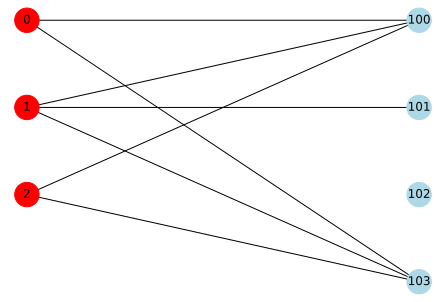

In [52]:
np.random.seed(seed=16)
np.set_printoptions(threshold=10000000)

B = nx.Graph()

user_num = 3
item_num = 4

user_nodes = [i for i in range(user_num)]
item_nodes = [i for i in range(100, 100 + item_num)]

B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)

node_color = []
node_size = [600 for i in range(user_num + item_num)]

for u in user_nodes:
  node_color.append('red')
for i in item_nodes:
  node_color.append('lightblue')

edge_nodes = []
pos = {}
for _i, u in enumerate(user_nodes):
  pos[u] = np.array([-1, - 1.75 * _i])
  for _j, i in enumerate(item_nodes):
    pos[i] = np.array([1, - 1.75 * _j])
    if np.random.random() < 0.45:
      edge_nodes.append((u,i))

B.add_edges_from(edge_nodes)

nx.draw(B, pos=pos, with_labels=True, node_color=node_color, node_size=node_size)

plt.show()

上の二部グラフを嗜好行列で表すと以下のようになります。

|  | item_100 | item_200 | item_300 | item_400 |
| :---: | :---: | :---: | :---: | :---: |
| user_0 | 1 | 0 | 0 | 1 |
| user_1 | 1 | 1 | 0 | 1 |
| user_2 | 1 | 0 | 0 | 1 |

networkx型のオブジェクトから、嗜好行列や隣接行列を作ることができます。

In [53]:
A = np.array(nx.adjacency_matrix(B).todense())
L = np.array(nx.laplacian_matrix(B).todense())
D = L + A
A

array([[0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0]], dtype=int64)

In [54]:
R = A[0:user_num, user_num:]
R

array([[1, 0, 0, 1],
       [1, 1, 0, 1],
       [1, 0, 0, 1]], dtype=int64)

In [55]:
D_I = np.sum(R, axis=0)
D_I

array([3, 1, 0, 3], dtype=int64)

In [56]:
D_U = np.sum(R, axis=1)
D_U

array([2, 3, 2], dtype=int64)

In [57]:
R_hat = np.diag(np.power(D_U + 1e-15, -1/2)) @ R @ np.diag(np.power(D_I + 1e-15, -1/2))
R_hat.round(2)

array([[0.41, 0.  , 0.  , 0.41],
       [0.33, 0.58, 0.  , 0.33],
       [0.41, 0.  , 0.  , 0.41]])

In [58]:
A_hat = np.block([[A[:user_num, :user_num], R_hat], [R_hat.T, A[user_num:, user_num:]]])
A_hat.round(2)

array([[0.  , 0.  , 0.  , 0.41, 0.  , 0.  , 0.41],
       [0.  , 0.  , 0.  , 0.33, 0.58, 0.  , 0.33],
       [0.  , 0.  , 0.  , 0.41, 0.  , 0.  , 0.41],
       [0.41, 0.33, 0.41, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.58, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.41, 0.33, 0.41, 0.  , 0.  , 0.  , 0.  ]])

In [59]:
# user-user 正規化隣接行列
P_item_hat = R_hat @ R_hat.T
P_item_hat.round(2)

array([[0.33, 0.27, 0.33],
       [0.27, 0.56, 0.27],
       [0.33, 0.27, 0.33]])

In [60]:
# item-item 正規化隣接行列
P_user_hat = R_hat.T @ R_hat
P_user_hat.round(2)

array([[0.44, 0.19, 0.  , 0.44],
       [0.19, 0.33, 0.  , 0.19],
       [0.  , 0.  , 0.  , 0.  ],
       [0.44, 0.19, 0.  , 0.44]])

In [61]:
n_users = 3
n_items = 4
embedding_size = 64

user_embedding = nn.Embedding(n_users, embedding_size)
item_embedding = nn.Embedding(n_items, embedding_size)


In [62]:
user_embedding

Embedding(3, 64)

In [63]:
item_embedding

Embedding(4, 64)

In [64]:
def forward(X, A_hat):
  H = torch.mm(torch.mm(A_hat, X), self.W_0)
  H = F.relu(H)
  H = torch.mm(torch.mm(A_hat, H),self.W_1)
  return F.log_softmax(H, dim=1)

In [65]:
class GCN(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden, num_class):
    super(GCN, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.num_class = num_class
    self.A_hat = A_hat
    self.W_0 = nn.Parameter(torch.Tensor(num_feat, num_hidden))
    self.W_1 = nn.Parameter(torch.Tensor(num_hidden, num_class))
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.W_0.size(1))
    self.W_0.data.uniform_(-stdv, stdv)
    stdv = 1. / math.sqrt(self.W_1.size(1))
    self.W_1.data.uniform_(-stdv, stdv)

  def forward(self, X, A_hat):
    H = torch.mm(torch.mm(A_hat, X), self.W_0)
    H = F.relu(H)
    H = torch.mm(torch.mm(A_hat, H),self.W_1)
    return F.log_softmax(H, dim=1)

pytorchの場合は

## Graph Convolutional Networks 

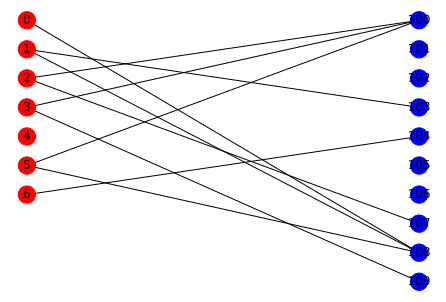

In [66]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.set_printoptions(threshold=10000000)

B = nx.Graph()

user_num = 7
item_num = 10

user_nodes = [i for i in range(user_num)]
item_nodes = [i for i in range(100, 100 + item_num)]

B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)

node_color = []

for u in user_nodes:
  node_color.append('red')
for i in item_nodes:
  node_color.append('blue')

edge_nodes = []
pos = {}
for _i, u in enumerate(user_nodes):
  pos[u] = np.array([-1, - 1.75 * _i])
  for _j, i in enumerate(item_nodes):
    pos[i] = np.array([1, - 1.75 * _j])
    if np.random.random() < 0.15:
      edge_nodes.append((u,i))

B.add_edges_from(edge_nodes)

nx.draw(B, pos=pos, with_labels=True, node_color=node_color)

plt.show()

In [67]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()

print(loss)

# 入力のサイズはN x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)

print(input)
# ターゲットの各要素は0 <=値<Cである必要があります
target = torch.tensor([1, 0, 4])
print(target)
output = loss(m(input), target)
print(output)
output.backward()

NLLLoss()
tensor([[-2.1383, -0.6961, -1.1747,  2.1168, -1.4791],
        [ 1.8073,  1.5682,  0.5385,  1.5459, -0.0277],
        [ 1.3852, -1.1378,  0.1540, -0.5693,  1.8205]], requires_grad=True)
tensor([1, 0, 4])
tensor(1.5746, grad_fn=<NllLossBackward0>)


レコメンドにおけるグラフは、通常2部グラフとして表現されます。

$$
\tilde{R}=D_{U}^{-\frac{1}{2}} R D_{I}^{-\frac{1}{2}}
$$

networkxにはグラフラプラシアン$L$を求める関数が酔いされています。
$$
L=D-A
$$

次数行列は以下の様に求める事が出来ます。

$$
D = L + A
$$

## グラフラプラシアンの正規化

$$
\tilde{L}=I-\tilde{A}
$$

$$
\Delta f=\frac{\partial^{2} f}{\partial x^{2}}+\frac{\partial^{2} f}{\partial y^{2}}+\frac{\partial^{2} f}{\partial z^{2}}
$$

$$
\Delta h_{\omega}(x)=\lambda_{\omega} h_{\omega}(x)
$$

$$
h_{\omega}(x)=e^{i \omega x}
$$

$$
g(t) * f(t)=\sum_{\tau} g(\tau) f(t-\tau)
$$

$$
F[g(t) * f(t)]=F[g(t)] F[f(t)]
$$

$$
\begin{gathered}
\hat{\mathbf{x}}=\mathbf{U}^{T} \mathbf{x} \\
\mathbf{x}=\mathbf{U} \widehat{\mathbf{x}}
\end{gathered}
$$

$$
\mathcal{H}(\boldsymbol{L})=\operatorname{UDiag}\left(h\left(\lambda_{1}\right), \cdots, h\left(\lambda_{n}\right)\right) U^{T}
$$

In [68]:
import torch
from torch.utils.data import DataLoader, Dataset

from SVDppRecommender import SVDpp

class RateDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]
    
    def __len__(self):
        return self.user_tensor.size(0)

data = {(0,0): 4, 
        (0,1): 5, 
        (0,2): 3,
        (0,3): 4, 
        (1,0): 5, 
        (1,1): 3,
        (1,2): 4, 
        (1,3): 1, 
        (2,0): 3,
        (2,1): 2, 
        (2,2): 5, 
        (2,3): 5,
        (3,0): 4, 
        (3,1): 2, 
        (3,2): 3,
        (3,3): 1
        }
Iu = {key:[0,1,2,3] for key in range(4)}

user_tensor = torch.LongTensor([key[0] for key in data.keys()])
item_tensor = torch.LongTensor([key[1] for key in data.keys()])
rating_tensor = torch.FloatTensor([val for val in data.values()])

params = {'num_users': 4, 
          'num_items': 4,
          'global_mean': 3, 
          'latent_dim': 10
        }

model = SVDpp(params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

dataset = RateDataset(user_tensor, item_tensor, rating_tensor)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

for epoch in range(30):
    for bid, batch in enumerate(train_loader):
        u, i, r = batch[0], batch[1], batch[2]
        r = r.float()
        # forward pass
        preds = model(u, i, Iu)
        loss = criterion(preds, r)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/30], Loss: {:.4f}'.format(epoch + 1, loss.item()))
    

ModuleNotFoundError: No module named 'SVDppRecommender'

In [69]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(A_hat)
H = model.components_

In [70]:
X

array([[1. , 1. ],
       [2. , 1. ],
       [3. , 1.2],
       [4. , 1. ],
       [5. , 0.8],
       [6. , 1. ]])

In [71]:
W

array([[1.55391099e-11, 3.40767530e-01],
       [0.00000000e+00, 4.17373793e-01],
       [1.55391099e-11, 3.40767530e-01],
       [5.83954597e-01, 0.00000000e+00],
       [3.37146309e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [5.83954597e-01, 0.00000000e+00]])

In [72]:
H

array([[5.99236855e-01, 7.33912241e-01, 5.99236855e-01, 2.27854326e-12,
        0.00000000e+00, 0.00000000e+00, 2.27854326e-12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.02685282e+00,
        5.92873174e-01, 0.00000000e+00, 1.02685282e+00]])

In [73]:
np.dot(W, H).round(2)

array([[0.  , 0.  , 0.  , 0.35, 0.2 , 0.  , 0.35],
       [0.  , 0.  , 0.  , 0.43, 0.25, 0.  , 0.43],
       [0.  , 0.  , 0.  , 0.35, 0.2 , 0.  , 0.35],
       [0.35, 0.43, 0.35, 0.  , 0.  , 0.  , 0.  ],
       [0.2 , 0.25, 0.2 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.43, 0.35, 0.  , 0.  , 0.  , 0.  ]])